In [8]:
# Define the plot size
options(repr.plot.width = 24, repr.plot.height = 12)

# Import libraries
library(ggplot2)

First 5 rows of data:
        Date Close.Price..USD.
1 2014-09-17           457.334
2 2014-09-18           424.440
3 2014-09-19           394.796
4 2014-09-20           408.904
5 2014-09-21           398.821

Dataset info:
'data.frame':	3758 obs. of  2 variables:
 $ Date             : Date, format: "2014-09-17" "2014-09-18" ...
 $ Close.Price..USD.: num  457 424 395 409 399 ...

Summary statistics:
      Date            Close.Price..USD. 
 Min.   :2014-09-17   Min.   :   178.1  
 1st Qu.:2017-04-13   1st Qu.:  1224.9  
 Median :2019-11-08   Median :  9349.5  
 Mean   :2019-11-08   Mean   : 19566.2  
 3rd Qu.:2022-06-04   3rd Qu.: 30540.1  
 Max.   :2024-12-30   Max.   :106140.6  


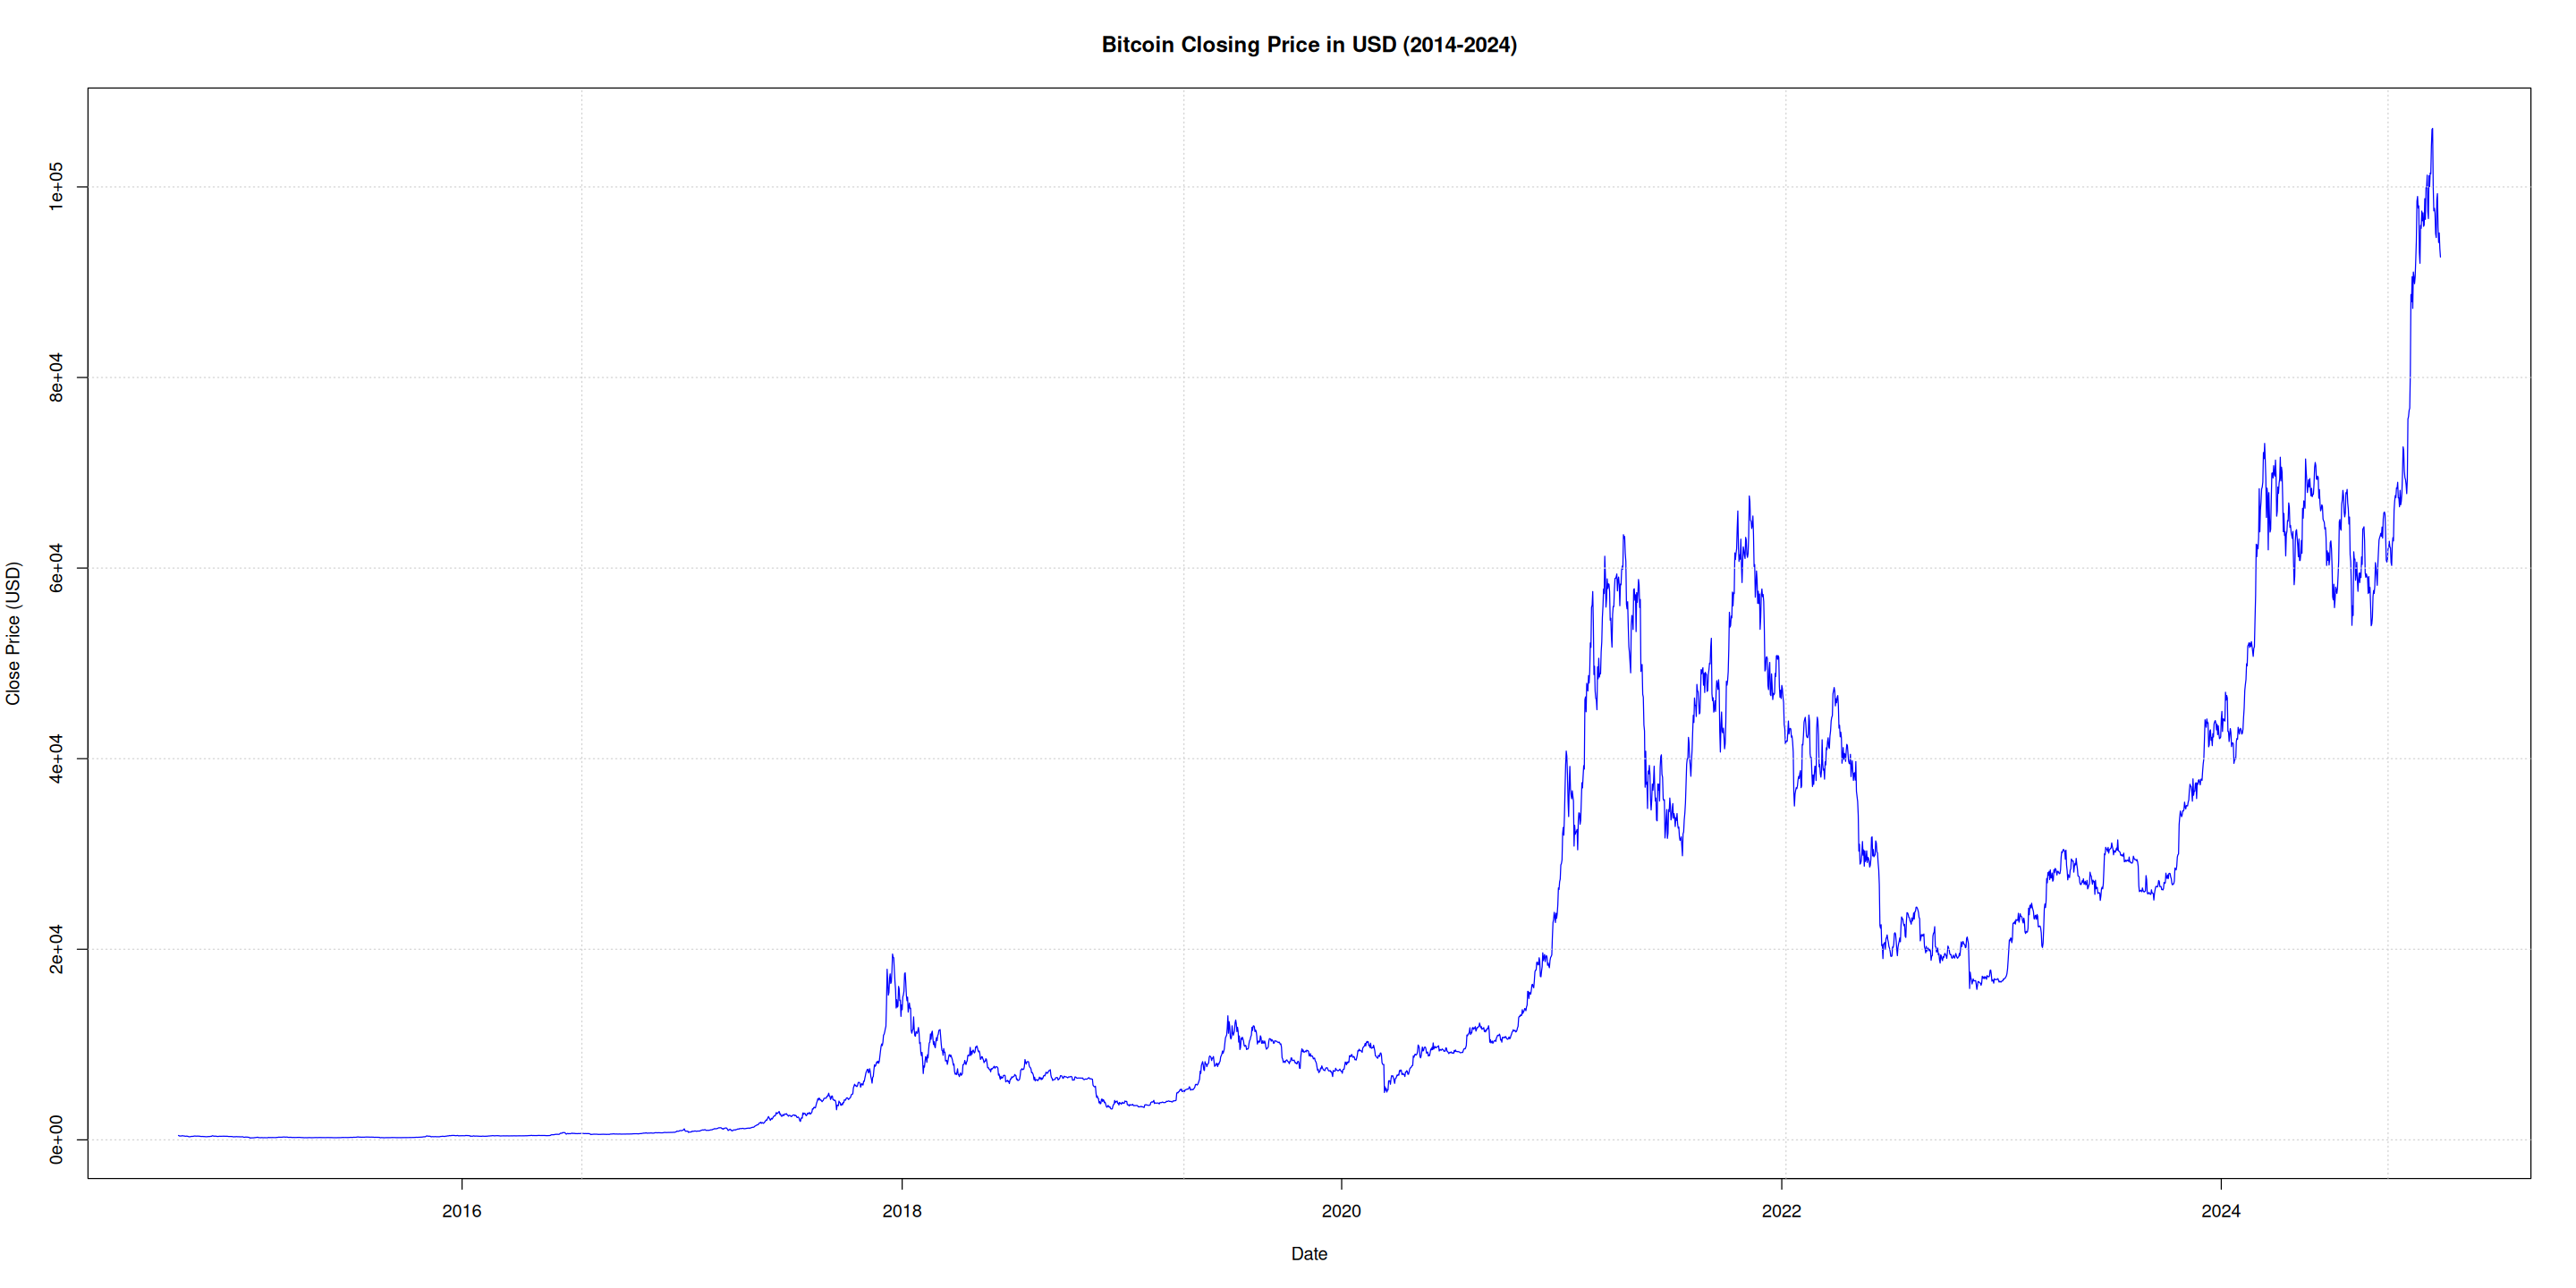

In [10]:
# Load the Bitcoin data
bitcoin_data <- read.csv("../data/bitcoin_data.csv")

# Convert the Date column to Date format
bitcoin_data$Date <- as.Date(bitcoin_data$Date)

# Display the first few rows
cat("First 5 rows of data:\n")
print(head(bitcoin_data, 5))

# Display basic information about the dataset
cat("\nDataset info:\n")
str(bitcoin_data)

# Display summary statistics
cat("\nSummary statistics:\n")
print(summary(bitcoin_data))

# Set the background color
par(bg = "white")

# Plot the Bitcoin closing price
plot(bitcoin_data$Date, bitcoin_data$Close, 
     type = "l",
     main = "Bitcoin Closing Price in USD (2014-2024)",
     xlab = "Date",
     ylab = "Close Price (USD)",
     col = "blue",
     lwd = 1)
grid()